<a href="https://colab.research.google.com/github/vimalthomas-db/deeplearning/blob/main/MPG_Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import requests
import io
import zipfile

Data_URL = "https://archive.ics.uci.edu/static/public/9/auto+mpg.zip"



def download_data(url):
    try:
        response = requests.get(url, stream=True)  # stream=True for large files
        response.raise_for_status()
        print("data downloaded successfully")

        with zipfile.ZipFile(io.BytesIO(response.content)) as zf:  # Open zip file
            with zf.open('auto-mpg.data') as data_file:  # Open data file inside zip
                df = pd.read_csv(
                    data_file,
                    delim_whitespace=True,
                    header=None,
                    names=[
                        'mpg', 'cylinders', 'displacement', 'horsepower',
                        'weight', 'acceleration', 'model_year', 'origin',
                        'car_name'
                    ],
                    na_values='?'
                )
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error downloading:L {e}")
        return None
    except (zipfile.BadZipFile, KeyError) as e:
        print(f"Error extracting data from zip file: {e}")
        return None

def check_missing(dataframe):

    missing = pd.DataFrame({'Feature': dataframe.columns,
                           'Missing': [dataframe[i].isnull().sum() for i in dataframe.columns],
                           'Ratio': [100 * dataframe[i].isnull().sum() / dataframe.shape[0] \
                                    for i in dataframe.columns]})
    missing = missing[missing['Missing'] > 0]

    if missing.shape[0] == 0:
        print('No missing values')
    else:
        missing = missing.reset_index(drop = True)
        missing = missing.sort_values('Missing', ascending = False)
        return missing

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car



In [85]:
df = download_data(Data_URL)

display(df)

data downloaded successfully


<ipython-input-84-5650372375dc>:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


In [86]:
def auto_preprocess(dataframe):
    df_ = dataframe.copy()
    auto_misspelled = {'chevroelt': 'chevrolet',
                       'chevy': 'chevrolet',
                       'vokswagen': 'volkswagen',
                       'vw': 'volkswagen',
                       'hi': 'harvester',
                       'maxda': 'mazda',
                       'toyouta': 'toyota',
                       'mercedes-benz': 'mercedes'}
    df_['make'] = [auto_misspelled[key].title() if key in auto_misspelled else
                   key.title() for key in [i.split()[0] for i in df_['car_name']]]
    df_['name'] = [' '.join(i.split()[1:]).title() for i in df_['car_name']]

    df_ = df_.drop(columns = ['car_name'], axis = 1)
    return df_

df = auto_preprocess(df)


In [87]:
display(df)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,make,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,Chevrolet,Chevelle Malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,Buick,Skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,Plymouth,Satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,Amc,Rebel Sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,Ford,Torino
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,Ford,Mustang Gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,Volkswagen,Pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,Dodge,Rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,Ford,Ranger


In [88]:
check_missing(df)

,Feature,Missing,Ratio
0,horsepower,6,1.507538


In [89]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 398
Variables: 10
cat_cols: 2
num_cols: 6
cat_but_car: 2
num_but_cat: 2


In [90]:
df.groupby(cat_cols).agg({'horsepower': ['mean','median']})

horsepower       
                        mean median
cylinders origin                   
3         3        99.250000   98.5
4         1        80.956522   84.0
          2        78.311475   76.0
          3        75.579710   70.0
5         2        82.333333   77.0
6         1        99.671233  100.0
          2       113.500000  122.5
          3       115.833333  118.0
8         1       158.300971  150.0

In [91]:
df.groupby(cat_cols).agg({'horsepower': ['mean','median']})
df['horsepower'] = df['horsepower'].fillna(df.groupby(cat_cols)['horsepower'].transform('median'))

check_missing(df)

No missing values


In [92]:
display(df)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,make,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,Chevrolet,Chevelle Malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,Buick,Skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,Plymouth,Satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,Amc,Rebel Sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,Ford,Torino
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,Ford,Mustang Gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,Volkswagen,Pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,Dodge,Rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,Ford,Ranger


In [93]:
def one_hot_encoder(dataframe, categorical_cols: list, drop_first: bool = False):
    dataframe = pd.get_dummies(dataframe,
                               columns=categorical_cols,
                               drop_first=drop_first,
                               dtype=int)  # Add dtype=int to get 1s and 0s
    return dataframe

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
print('Binary Features: {}'.format(binary_cols))

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols.append('make')
print('Multiclass Features: {}'.format(ohe_cols))

Binary Features: []
Multiclass Features: ['cylinders', 'origin', 'make']


In [94]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   make          398 non-null    object 
 9   name          398 non-null    object 
dtypes: float64(5), int64(3), object(2)
memory usage: 31.2+ KB


None

In [95]:
df['cylinders'] = df['cylinders'].astype(int)
df['origin'] = df['origin'].astype(int)

display(df)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,make,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,Chevrolet,Chevelle Malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,Buick,Skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,Plymouth,Satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,Amc,Rebel Sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,Ford,Torino
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,Ford,Mustang Gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,Volkswagen,Pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,Dodge,Rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,Ford,Ranger


In [96]:

df = one_hot_encoder(df, ohe_cols)
df.head()

,mpg,displacement,horsepower,weight,acceleration,model_year,name,cylinders_3,cylinders_4,cylinders_5,...,make_Peugeot,make_Plymouth,make_Pontiac,make_Renault,make_Saab,make_Subaru,make_Toyota,make_Triumph,make_Volkswagen,make_Volvo
0,18.0,307.0,130.0,3504.0,12.0,70,Chevelle Malibu,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15.0,350.0,165.0,3693.0,11.5,70,Skylark 320,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18.0,318.0,150.0,3436.0,11.0,70,Satellite,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,16.0,304.0,150.0,3433.0,12.0,70,Rebel Sst,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17.0,302.0,140.0,3449.0,10.5,70,Torino,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 398
Variables: 45
cat_cols: 38
num_cols: 6
cat_but_car: 1
num_but_cat: 38


In [98]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.03).any(axis=None)]

print('Number of useless variables: {}'.format(len(useless_cols)))
df.drop(useless_cols, axis = 1, inplace=True)

Number of useless variables: 20


In [99]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mpg              398 non-null    float64
 1   displacement     398 non-null    float64
 2   horsepower       398 non-null    float64
 3   weight           398 non-null    float64
 4   acceleration     398 non-null    float64
 5   model_year       398 non-null    int64  
 6   name             398 non-null    object 
 7   cylinders_4      398 non-null    int64  
 8   cylinders_6      398 non-null    int64  
 9   cylinders_8      398 non-null    int64  
 10  origin_1         398 non-null    int64  
 11  origin_2         398 non-null    int64  
 12  origin_3         398 non-null    int64  
 13  make_Amc         398 non-null    int64  
 14  make_Buick       398 non-null    int64  
 15  make_Chevrolet   398 non-null    int64  
 16  make_Datsun      398 non-null    int64  
 17  make_Dodge      

None

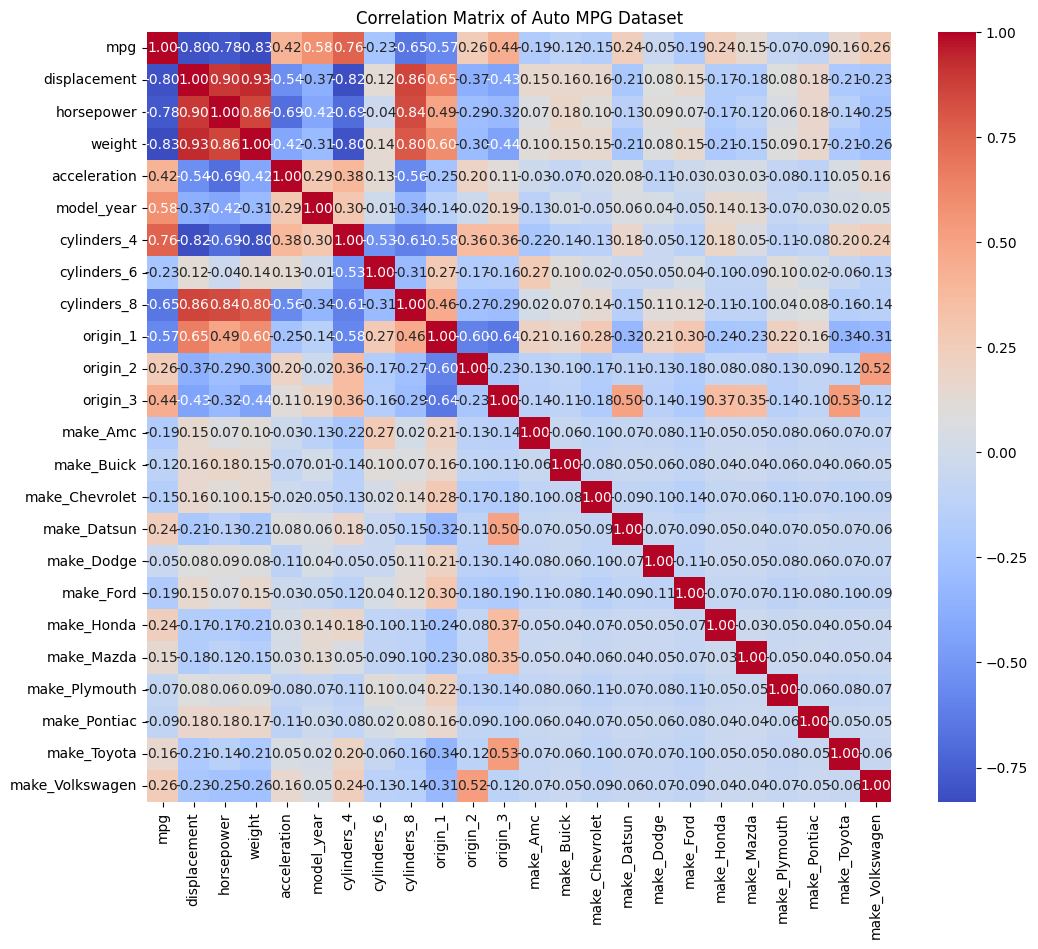

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the 'name' column
df_for_corr = df.drop(columns=['name'])

# Calculate the correlation matrix
corr_matrix = df_for_corr.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Auto MPG Dataset')
plt.show()

In [133]:
display(df_for_corr)

,mpg,displacement,horsepower,weight,acceleration,model_year,cylinders_4,cylinders_6,cylinders_8,origin_1,...,make_Chevrolet,make_Datsun,make_Dodge,make_Ford,make_Honda,make_Mazda,make_Plymouth,make_Pontiac,make_Toyota,make_Volkswagen
0,18.0,307.0,130.0,3504.0,12.0,70,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
1,15.0,350.0,165.0,3693.0,11.5,70,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,18.0,318.0,150.0,3436.0,11.0,70,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,16.0,304.0,150.0,3433.0,12.0,70,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17.0,302.0,140.0,3449.0,10.5,70,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,140.0,86.0,2790.0,15.6,82,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
394,44.0,97.0,52.0,2130.0,24.6,82,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
395,32.0,135.0,84.0,2295.0,11.6,82,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
396,28.0,120.0,79.0,2625.0,18.6,82,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [135]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming your DataFrame is called 'df'
# and the numerical features are: 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year'

# 1. Create a MinMaxScaler object
scaler = MinMaxScaler()

# 2. Select the numerical features to be normalized
numerical_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'model_year']

# 3. Fit the scaler on the entire DataFrame (df) and transform it
df_for_corr[numerical_features] = scaler.fit_transform(df_for_corr[numerical_features])

# Now, your numerical features in the entire DataFrame (df)
# will be scaled to the range [0, 1]

In [137]:
display(df_for_corr)

,mpg,displacement,horsepower,weight,acceleration,model_year,cylinders_4,cylinders_6,cylinders_8,origin_1,...,make_Chevrolet,make_Datsun,make_Dodge,make_Ford,make_Honda,make_Mazda,make_Plymouth,make_Pontiac,make_Toyota,make_Volkswagen
0,18.0,0.617571,0.456522,0.536150,0.238095,0.0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
1,15.0,0.728682,0.646739,0.589736,0.208333,0.0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,18.0,0.645995,0.565217,0.516870,0.178571,0.0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,16.0,0.609819,0.565217,0.516019,0.238095,0.0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17.0,0.604651,0.510870,0.520556,0.148810,0.0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,0.186047,0.217391,0.333711,0.452381,1.0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
394,44.0,0.074935,0.032609,0.146583,0.988095,1.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
395,32.0,0.173127,0.206522,0.193365,0.214286,1.0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
396,28.0,0.134367,0.179348,0.286929,0.630952,1.0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [138]:
import numpy as np
np.random.seed(42)
shuffled_indices = np.random.permutation(len(df_for_corr))
train_size = int(0.7 * len(df_for_corr))
val_size = int(0.15 * len(df_for_corr))
test_size = len(df_for_corr) - train_size - val_size

train_indices = shuffled_indices[:train_size]
val_indices = shuffled_indices[train_size:train_size + val_size]
test_indices = shuffled_indices[train_size + val_size:]

train_x, train_y = df_for_corr.iloc[train_indices].drop(columns=["mpg"]).values, df_for_corr.iloc[train_indices]["mpg"].values
val_x, val_y =     df_for_corr.iloc[val_indices].drop(columns=["mpg"]).values, df_for_corr.iloc[val_indices]["mpg"].values
test_x, test_y =   df_for_corr.iloc[test_indices].drop(columns=["mpg"]).values, df_for_corr.iloc[test_indices]["mpg"].values

train_y = train_y.reshape(-1, 1)
val_y = val_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)


print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(278, 23) (278, 1)
(59, 23) (59, 1)
(61, 23) (61, 1)


In [167]:
# Clone the GitHub repository (if required)
!git clone https://github.com/vimalthomas/deeplearning.git
%cd deeplearning/
# Run the specific notebook/script
%run "Multilayerperceptron_drop.ipynb"

Cloning into 'deeplearning'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 144 (delta 5), reused 2 (delta 2), pack-reused 134 (from 1)
Receiving objects: 100% (144/144), 136.65 KiB | 13.66 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/deeplearning/deeplearning/deeplearning/deeplearning/deeplearning/deeplearning/deeplearning/deeplearning/deeplearning/deeplearning/deeplearning/deeplearning


In [168]:
mlp = MultilayerPerceptron([
    Layer(train_x.shape[1], 256, Tanh(), dropout_rate=0.02),
    Layer(256, 128, Tanh(), dropout_rate=0.02),
    Layer(128, 64, Tanh(), dropout_rate=0.02),
    Layer(64, 64, Tanh(), dropout_rate=0.02),
    Layer(64, 1, Linear())
])

loss_function = SquaredError()
train_losses, val_losses = mlp.train(
    train_x=train_x, train_y=train_y,
    val_x=val_x, val_y=val_y,
    loss_func=loss_function,
    learning_rate=0.0001, batch_size=32, epochs=2000, model_type='regression'
)

Epoch 1/2000 - Training MSE: 618.0328 - Validation MSE: 560.5637 - Training MAE: 23.6934 - Validation MAE: 22.4015 - Training R²: -9.1217 - Validation R²: -7.9049
Epoch 2/2000 - Training MSE: 613.7859 - Validation MSE: 556.5919 - Training MAE: 23.6055 - Validation MAE: 22.3400 - Training R²: -9.0521 - Validation R²: -7.8418
Epoch 3/2000 - Training MSE: 612.1457 - Validation MSE: 557.7673 - Training MAE: 23.5694 - Validation MAE: 22.3460 - Training R²: -9.0253 - Validation R²: -7.8604
Epoch 4/2000 - Training MSE: 610.1879 - Validation MSE: 553.0458 - Training MAE: 23.5266 - Validation MAE: 22.2606 - Training R²: -8.9932 - Validation R²: -7.7854
Epoch 5/2000 - Training MSE: 606.7698 - Validation MSE: 552.6498 - Training MAE: 23.4606 - Validation MAE: 22.2463 - Training R²: -8.9372 - Validation R²: -7.7791
Epoch 6/2000 - Training MSE: 604.0342 - Validation MSE: 548.2928 - Training MAE: 23.4038 - Validation MAE: 22.1559 - Training R²: -8.8924 - Validation R²: -7.7099
Epoch 7/2000 - Trainin

ValueError: x and y must have same first dimension, but have shapes (500,) and (1000,)

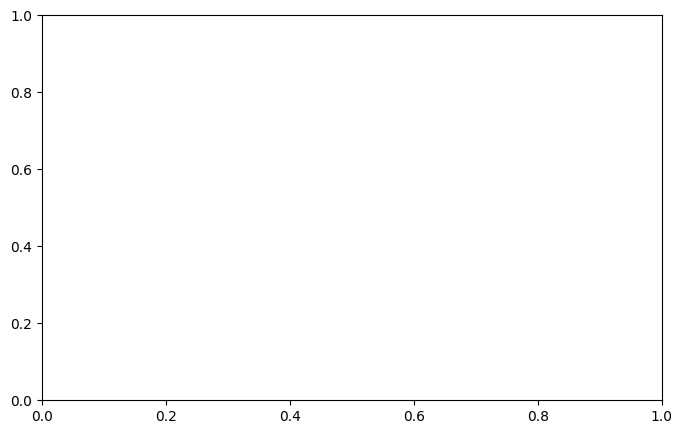

In [162]:
plt.figure(figsize=(8, 5))
epochs = np.arange(1, 501)
plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [165]:
# ... (your training code) ...

print("Total Training Loss:", train_losses[-1])  # Prints the last recorded training loss
print("Total Validation Loss:", val_losses[-1]) # Prints the last recorded validation loss

Total Training Loss: 2.5281034438383996
Total Validation Loss: 6.999355445304643
